# 6. 일급 함수 디자인 패턴
- 목차
    - 6.1. 전략 패턴의 리팩토링
    - 6.1.1. 고전적 전략 패턴
    - 6.1.2. 함수지향 전략
    - 6.1.3. 최선의 전략 선택: 단순 접근법
    - 6.1.4. 모듈에서 전략 찾기
    - 6.2. 명령
    - 6.3. 요약
- 디자인 패턴:
    - 프로그램 개발에서 자주 나타나는 과제를 해결하기 위한 방법 중 하나
    - 과거의 소프트웨어 개발 과정에서 발견된 설계의 노하우를 축적하여 이름을 붙여, 이후에 재이용하기 좋은 형태로 특정의 규약을 묶어서 정리한 것
    - 알고리즘과 같이 프로그램 코드로 바로 변환될 수 있는 형태는 아니지만, 특정한 상황에서 구조적인 문제를 해결하는 방식을 설명해 줌
- ABC 클래스
    - https://wikidocs.net/16075

## 6.1. 사례: 전략 패턴의 리팩토링
- 전략 패턴: 일련의 알고리즘을 정의하고 각각을 하나의 클래스 안에 넣어서 교체하기 쉽게 만든다.  
  전략을 이용하면 사용하는 클라이언트에 따라 알고리즘을 독립적으로 변경할 수 있다.
- 함수를 일급 객체로 사용하면 더욱 간단해질 수 있는 디자인 패턴의 대표적 사례
- 고전적 패턴 $\rightarrow$ 함수지향 전략

### 6.1.1. 고전적인 전략
- 예: 할인 규칙
    - 충성도 포인트각 1000점 이상이면 전체 주문에 5% 할인
    - 하나의 주문에 20개 이상 동일 상품 구입하면 해당 상품에 대해 10% 할인
    - 서로 다른 상품 10종류 이상 주문하면 전체 주문에 대해 7% 할인
- 구성 요소:
    - 콘텍스트: Order
    - 전략: Promotion
    - 구체적인 전략: FIdelityPromo, BulkItemPromo, LargeOrderPromo
- 하나의 주문에는 하나의 Promotion만 적용

In [2]:
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
def load_img(name, img_dir='images/'):
    img = misc.imread(img_dir + name)
    plt.imshow(img)
    plt.subplots_adjust(right=2, top=2)

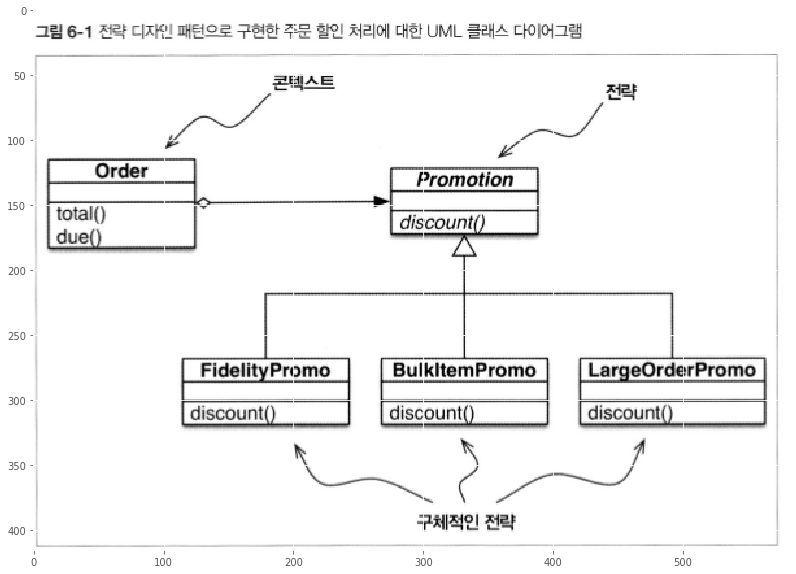

In [4]:
load_img('fig6-1.png')

In [5]:
from abc import ABC, abstractmethod
from collections import namedtuple

In [6]:
Customer = namedtuple('Customer', ['name', 'fidelity'])

class LineItem(object):
    
    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price
        
    def total(self):
        return self.price * self.quantity
    
    
class Order(object):
    
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = cart
        self.promotion = promotion
        
    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total
    
    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion.discount(self)
        return self.total() - discount
    
    def __repr__(self):
        fmt = '<Order total: {:.2f} due:{:.2f}>'
        return fmt.format(self.total(), self.due())
    
    
class Promotion(ABC):
    
    @abstractmethod
    def discount(self, order):
        pass
    

class FidelityPromo(Promotion):
    
    def discount(self, order):
        return order.total() * .05 if order.customer.fidelity >= 1000 else 0
    
    
class BulkItemPromo(Promotion):
    
    def discount(self, order):
        discount = 0
        for item in order.cart:
            if item.quantity >= 20:
                discount += item.total() * .1        
        return discount
    
    
class LargeOrderPromo(Promotion):
    
    def discount(self, order):
        distinct_items = {item.product for item in order.cart}
        if len(distinct_items) >= 10:
            return order.total() * .07
        return 0

In [7]:
# 이름, 충성도
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)

# 상품, 갯수, 가격
cart = [
    LineItem('banana', 4, .5),
    LineItem('apple', 10, 1.5),
    LineItem('watermellon', 5, 5.0),
]

# 고객, 장바구니, 프로모션
# FidelityPromo: 충성도 1000 이상이면 5% 할인
print(Order(joe, cart, FidelityPromo()))
print(Order(ann, cart, FidelityPromo()))

<Order total: 42.00 due:42.00>
<Order total: 42.00 due:39.90>


In [8]:
banana_cart = [
    LineItem('banana', 30, .5),
    LineItem('apple', 10, 1.5),
]
# BulkItemPromo: 특정 상품 20개 이상 주문하면 해당 상품 10% 할인
print(Order(joe, banana_cart, BulkItemPromo()))

<Order total: 30.00 due:28.50>


In [9]:
long_order = [
    LineItem(str(item_code), 1, 1.0)
    for item_code in range(10)
]

# LargeOrderPromo: 10종류 이상 구매하면 7% 할인
print(Order(joe, long_order, LargeOrderPromo()))
print(Order(joe, cart, LargeOrderPromo()))

<Order total: 10.00 due:9.30>
<Order total: 42.00 due:42.00>


## 6.1.2. 함수지향 전략
- 6.1.1.의 구체적인 전략
    - 각 클래스는 discount() 메서드 하나만을 갖음
    - 전략 객체는 상태(객체 속성)을 갖지 않음
    - 전략 객체가 일반 함수와 다를바 없음

In [10]:
Customer = namedtuple('Customer', ['name', 'fidelity'])

class LineItem(object):
    
    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price
        
    def total(self):
        return self.price * self.quantity
    
    
class Order(object):
    
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = cart
        self.promotion = promotion
        
    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total
    
    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            # main differene
            discount = self.promotion(self)
        return self.total() - discount
    
    def __repr__(self):
        fmt = '<Order total: {:.2f} due:{:.2f}>'
        return fmt.format(self.total(), self.due())    


def fidelity_promo(order):
    return order.total() * .05 if order.customer.fidelity >= 1000 else 0
    
        
def bulk_item_promo(order):
    discount = 0
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * .1        
    return discount
    
    
def large_order_promo(order):
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * .07
    return 0

In [11]:
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)

cart = [
    LineItem('banana', 4, .5),
    LineItem('apple', 10, 1.5),
    LineItem('watermellon', 5, 5.0),
]

print(Order(joe, cart, fidelity_promo))
print(Order(ann, cart, fidelity_promo))

<Order total: 42.00 due:42.00>
<Order total: 42.00 due:39.90>


In [12]:
banana_cart = [
    LineItem('banana', 30, .5),
    LineItem('apple', 10, 1.5),
]

print(Order(joe, banana_cart, bulk_item_promo))

<Order total: 30.00 due:28.50>


In [13]:
long_order = [
    LineItem(str(item_code), 1, 1.0)
    for item_code in range(10)
]

print(Order(joe, long_order, large_order_promo))
print(Order(joe, cart, large_order_promo))

<Order total: 10.00 due:9.30>
<Order total: 42.00 due:42.00>


## 6.1.3. 최선의 전략 선택하기
- 새로운 할인 전략 추가되면 함수를 코딩하고 promos에 추가해야 됨

In [14]:
promos = [fidelity_promo, bulk_item_promo, large_order_promo]

def best_promo(order):
    return max(promo(order) for promo in promos)

In [15]:
print(Order(joe, long_order, best_promo))

<Order total: 10.00 due:9.30>


In [16]:
# 0.05 * 30
print(Order(joe, banana_cart, best_promo))

<Order total: 30.00 due:28.50>


In [17]:
print(Order(ann, cart, best_promo))

<Order total: 42.00 due:39.90>


## 6.2 .명령
- 명령패턴
    - 목적: 연산을 실행하는 객체와 연산을 구현하는 객체를 분리
    - 객체를 수신자, 호출자 사이에 놓고, 명령은 execute() 라는 단 하나의 메서드로 인터페이스를 구현

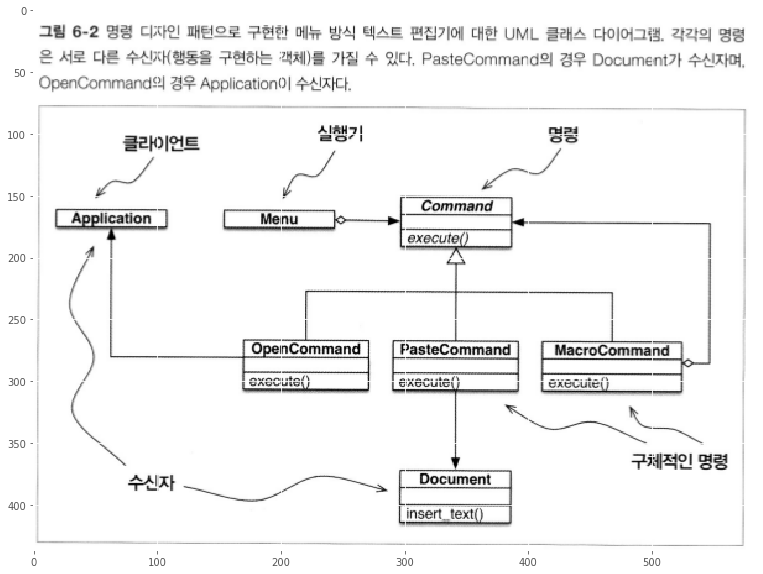

In [18]:
load_img('fig6-2.png')

- 디자인패턴에서 '명령은 콜백에 대한 객체지향식 대체물'이라 설명
- command.execute() 대신 command()만을 호출할수도 있음
- 실챙 취소 지원 등 고급 기능의 명령 패턴을 구현하려면?
    - 필요한 상태를 보관함으로써 __call__() 메서드 이외의 메서드를 제공
    - 함수가 호출된 후의 상태를 내부에 보관하기 위해 클로저를 사용

In [19]:
class MacroCommand:
    
    def __init__(self, commands):
        self.commands = commands
        
    def __call__(self):
        for command in self.commands:
            command()

- 요약:
    - 전략 패턴과 비슷
    - 단일 메서드 인터페이스를 구현하는 클래스의 객체를 콜러블로 대체
    - 모든 파이썬 콜러블이 __call__()이라는 단일 메서드 인터페이스를 구현하기 때문에 가능!